This notebook shows how the ROC curves for differential isoform usage in the superTranscript paper were produced (Figure 2B). Count values were obtained using the appropriate method (see "bash_commands.txt"). These were subsequently analysed with DEXSeq (see "DEXY.R"). The DEXSeq tables (a list of p-values for each gene) are input as the starting point for the code below. The association between cluster and gene ID is also created prior, using blat (see our paper for more description).

In [3]:
#Get mapping of clusters to gene
mapping <- read.delim("truth/cluster_gene_mapping.txt",sep="\t",header=F,stringsAsFactors=FALSE)
names(mapping) = c("cluster_id","gene_id")
head(mapping)

cluster_id,gene_id
Cluster-10003.0,ENSG00000171365
Cluster-10005.0,ENSG00000132801
Cluster-10008.0,ENSG00000138336
Cluster-10009.0,ENSG00000146067
Cluster-1001.0,ENSG00000125740
Cluster-10015.0,ENSG00000197056


In [9]:
message("split cluster (>1 means the gene is fragmented in the assembly)")
table(table(mapping$gene_id)) 

message("how many genes a cluster matches (>1 = possible false chimera)")
table(table(mapping$cluster_id))

#we will leave all these in the analysis. If a cluster matches multiple genes
#we chose the gene with the lowest p-value. If a gene matches multiple clusters
#we choose the cluster with the lower p-value. This ensures cluster-to-gene 
#mapping is one-to-one.


split cluster (>1 means the gene is fragmented in the assembly)



   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   18 
4849 3447 2046 1047  603  332  173  118   53   28   22   10   10    5    2    1 
  19   21 
   2    1 

how many genes a cluster matches (>1 = possible false chimera)



    1     2     3     4     5     6     7     8    10    11    12    15 
25283  2090   254    53    10     9     6     2     2     1     1     1 

In [11]:
#Get DEXSeq Table for each method
read_DTU_results<-function(file){
   pval<-read.delim(file,stringsAsFactors=FALSE)
   colnames(pval)<-c("cluster_id","adjP")
   print("Number of results:")
   print(dim(pval)[1])
   return(pval)
}
#truth
dex_k_truth=read_DTU_results("truth/kallisto/DEXY.txt")
dex_f_truth=read_DTU_results("truth/featureCounts/DEXY.txt")

#de novo
dex_k = read_DTU_results("kallisto/DEXY.txt")
dex_sal = read_DTU_results("salmon/DEXY.txt")
dex_rsem = read_DTU_results("rsem/DEXY.txt")
dex_st = read_DTU_results("ST/DEXY.txt")
dex_st_dyn = read_DTU_results("ST_dynamic/DEXY.txt")


[1] "Number of results:"
[1] 14551
[1] "Number of results:"
[1] 12855
[1] "Number of results:"
[1] 9565
[1] "Number of results:"
[1] 9577
[1] "Number of results:"
[1] 9214
[1] "Number of results:"
[1] 8795
[1] "Number of results:"
[1] 9997


In [12]:
# define the "Truth"

lower_cut=0.05  #true positive - p < 0.05
upper_cut=0.9   #false positive - p > 0.9 

#featureCounts truth
true_f=dex_f_truth$cluster_id[dex_f_truth$adjP<lower_cut]
false_f=dex_f_truth$cluster_id[dex_f_truth$adjP>upper_cut]

#kallisto truth
true_k=dex_k_truth$cluster_id[dex_k_truth$adjP<lower_cut]
false_k=dex_k_truth$cluster_id[dex_k_truth$adjP>upper_cut]

#take the intersection
true=true_f[true_f %in% true_k]
false=false_f[false_f %in% false_k]

length(true)
length(false)

truth<-c(rep(1,length(true)),rep(0,length(false)))
names(truth)<-c(true,false)

head(truth)


[1] 408

[1] 3132

ENSG00000004799 ENSG00000005893 ENSG00000006576 ENSG00000006652 ENSG00000010244 
              1               1               1               1               1 
ENSG00000010270 
              1

In [13]:
# Suppliment the results with the truth

# But only include clusters with mapped gene results
valid=mapping$gene_id %in% names(truth)
valid_genes=unique(mapping$gene_id[valid])
valid_clusters=unique(mapping$cluster_id[valid])
mapping=mapping[mapping$gene_id %in% valid_genes,]

seed<-0
add_truth<-function(result){
    missing=valid_clusters[!(valid_clusters %in% result$cluster_id)]
    to_add<-data.frame(missing,rep(1,length(missing)))
    colnames(to_add)<-c("cluster_id","adjP")
    result<-rbind(result,to_add) #add in the missing clusters
    result=result[result$cluster_id %in% valid_clusters,] #remove cluster with no gene match

    #add truth information
    #Note the match below will report the first gene match if mutliple genes match a cluster
    #This will be the gene with the lowest p-value
    result$gene_id=mapping$gene_id[match(result$cluster_id,mapping$cluster_id)]
    result$gene_ds_status=truth[result$gene_id]
    
    #randomise the order to make a smooth curve (in case muti-genes with the same p-value)
    set.seed(seed)
    seed<<-seed+1
    result=result[sample(1:length(result$cluster_id)),]
    
    #show(dim(result))
    return(result)
}
dex_k=add_truth(dex_k)
dex_sal=add_truth(dex_sal)
dex_rsem=add_truth(dex_rsem)
dex_st=add_truth(dex_st)
dex_st_dyn=add_truth(dex_st_dyn)
head(dex_k)

,cluster_id,adjP,gene_id,gene_ds_status
14209,Cluster-41584.0,1,ENSG00000143324,1
8942,Cluster-438.0,1,ENSG00000125122,0
10251,Cluster-15375.0,1,ENSG00000249709,0
11764,Cluster-26862.0,1,ENSG00000124782,0
14292,Cluster-42109.0,1,ENSG00000142173,1
7041,Cluster-37076.0,1,ENSG00000149489,0


In [14]:
#Calculate the rates
rate = function(dfs_final){
    
    #Rank by P-val
    dfs_final = dfs_final[order(dfs_final$adjP),]
    
    #Just take the first intance (highest rank) cluster for each gene
    #Ignore the other clusters which map to that gene effectively
    dfs_final= dfs_final[!duplicated(dfs_final$gene_id), ]
       
    #CumSum
    dfs_final$cumtp = cumsum(dfs_final$gene_ds_status)
    dfs_final$cumtn = cumsum(1 - dfs_final$gene_ds_status)
    
    #Normalise
    dfs_final$cumtp = dfs_final$cumtp/sum(dfs_final$gene_ds_status)
    dfs_final$cumtn = dfs_final$cumtn/sum(1-dfs_final$gene_ds_status)
    return(dfs_final)
}

In [15]:
#get cummulative values for the ROC curves
dk = rate(dex_k)
ds = rate(dex_st)
dsd = rate(dex_st_dyn)
dsal = rate(dex_sal)
drsem = rate(dex_rsem)
head(dk)

,cluster_id,adjP,gene_id,gene_ds_status,cumtp,cumtn
7365,Cluster-37995.0,0,ENSG00000170296,1,0.002463054,0.0000000000
7979,Cluster-39591.0,0,ENSG00000091317,0,0.002463054,0.0003775009
8553,Cluster-41137.0,0,ENSG00000138768,0,0.002463054,0.0007550019
8561,Cluster-41168.0,0,ENSG00000138674,1,0.004926108,0.0007550019
8835,Cluster-42079.0,0,ENSG00000038427,1,0.007389163,0.0007550019
8224,Cluster-40233.1,0,ENSG00000107796,1,0.009852217,0.0007550019


In [16]:
#Now combine all methods
dk$Method = 'Kallisto'
ds$Method = 'SuperTranscript (Standard)'
dsd$Method = "SuperTrancript (Dynamic)"
dsal$Method = 'Salmon'
drsem$Method = 'RSEM'
all<-rbind(ds,dsd)
all<-rbind(all,dk)
all<-rbind(all,dsal)
all<-rbind(all,drsem)
head(all)

,cluster_id,adjP,gene_id,gene_ds_status,cumtp,cumtn,Method
7859,Cluster-40964.0,0,ENSG00000072041,1,0.002463054,0.0000000000,SuperTranscript (Standard)
684,Cluster-15412.0,0,ENSG00000183309,0,0.002463054,0.0003775009,SuperTranscript (Standard)
6695,Cluster-37789.0,0,ENSG00000162520,1,0.004926108,0.0003775009,SuperTranscript (Standard)
7632,Cluster-40367.0,0,ENSG00000139278,1,0.007389163,0.0003775009,SuperTranscript (Standard)
6470,Cluster-37142.0,0,ENSG00000081307,1,0.009852217,0.0003775009,SuperTranscript (Standard)
7185,Cluster-39131.0,0,ENSG00000183576,0,0.009852217,0.0007550019,SuperTranscript (Standard)


pdf 
  2

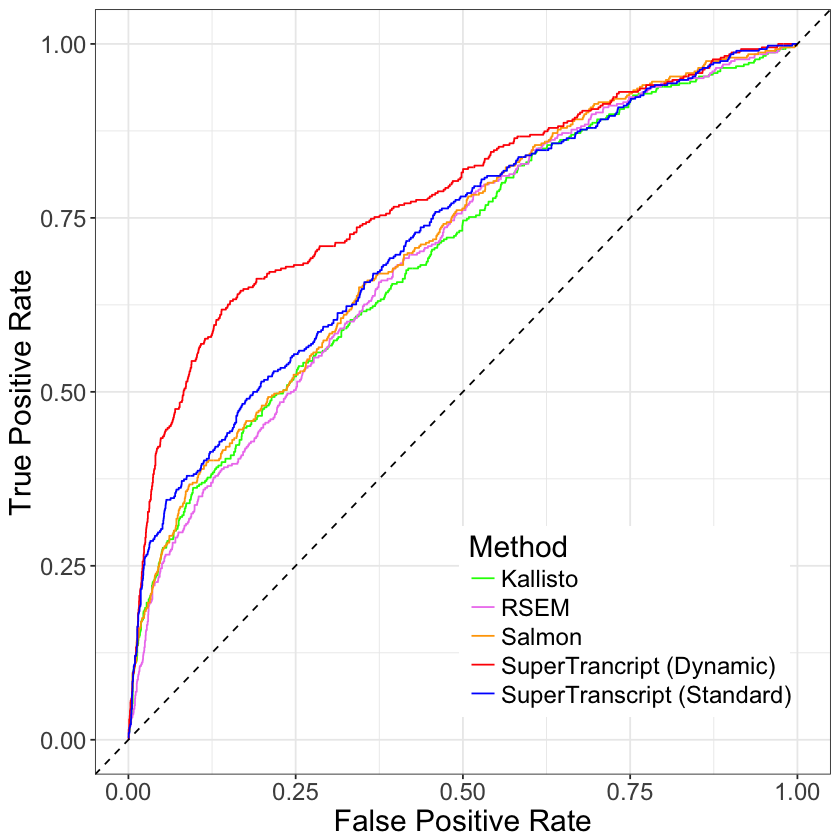

In [18]:
#Make the plot
library(ggplot2)
cbPalette<-c("green","violet","orange","red","blue")
p = ggplot(data=all,aes(x=cumtn,y=cumtp,group=Method,colour=Method)) + geom_line() 
p = p + geom_abline(intercept=0,slope=1,linetype=2) + xlim(0,1) +ylim(0,1) + theme_bw()
p = p + xlab('False Positive Rate') + ylab('True Positive Rate') + theme(text = element_text(size=18))
p = p + scale_colour_manual(values=cbPalette)
p=p+theme(legend.position=c(0.72,0.2))
p
pdf('ROC_curve.pdf')
p
dev.off()

In [25]:
## Get sensitivity and specificity at FDR=0.05

get_stats<-function(dX){
    sig=dX[(dX$adjP<0.05),]
    show(unique(dX$Method))
    show(paste("sensitivity:",sum(sig$gene_ds_status)/sum(dX$gene_ds_status)))
    show(paste("specificity",(length(sig$gene_ds_status)-sum(sig$gene_ds_status))/(length(dX$gene_ds_status)-sum(dX$gene_ds_status))))
}
get_stats(ds)
get_stats(dsd)
get_stats(dk)
get_stats(dsal)
get_stats(drsem)

[1] "SuperTranscript (Standard)"
[1] "sensitivity: 0.224137931034483"
[1] "specificity 0.0207625519063798"
[1] "SuperTrancript (Dynamic)"
[1] "sensitivity: 0.315270935960591"
[1] "specificity 0.0286900717251793"
[1] "Kallisto"
[1] "sensitivity: 0.199507389162562"
[1] "specificity 0.0302000755001888"
[1] "Salmon"
[1] "sensitivity: 0.197044334975369"
[1] "specificity 0.029445073612684"
[1] "RSEM"
[1] "sensitivity: 0.169950738916256"
[1] "specificity 0.0286900717251793"
